## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_cat = [col for col in data.columns if data[col].dtype == "O"]# fill your code here
vars_num = [col for col in data.columns if col not in vars_cat and col != "survived"]# fill your code here

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [11]:
# first in numerical variables
num_vars_na = [col for col in vars_num if data[col].isnull().sum() > 0]
data[num_vars_na].isnull().mean()

age     0.200917
fare    0.000764
dtype: float64

In [12]:
# now in categorical variables
cat_vars_na = [col for col in vars_cat if data[col].isnull().sum() > 0]
data[cat_vars_na].isnull().mean()

cabin       0.774637
embarked    0.001528
dtype: float64

### Determine cardinality of categorical variables

Text(0, 0.5, 'Unique values')

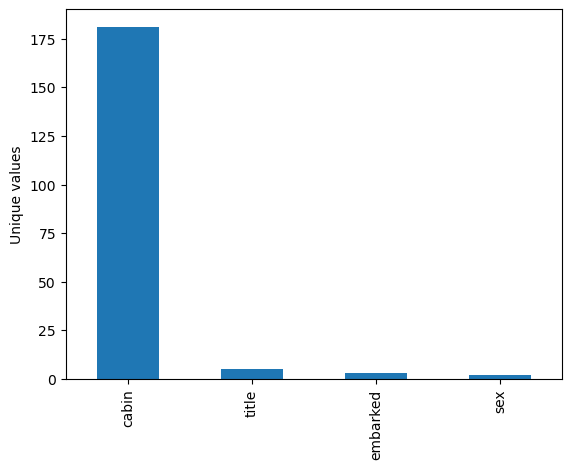

In [13]:
data[vars_cat].nunique().sort_values(ascending=False).plot.bar()
plt.ylabel("Unique values")

### Determine the distribution of numerical variables

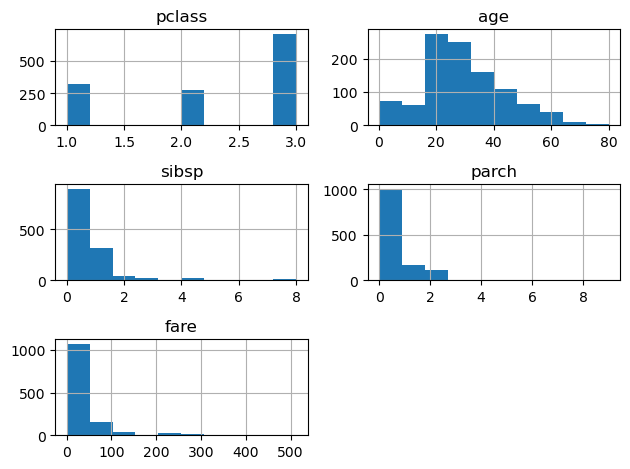

In [14]:
data[vars_num].hist()
plt.tight_layout()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [16]:
def extract_letter_from_cabin(cabin):
    try:
        return re.search(r"[A-Z]", cabin)[0]
    except:
        return np.nan

In [17]:
X_train["cabin"] = X_train["cabin"].apply(lambda c: extract_letter_from_cabin(c))
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr
44,1,female,41.0,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss
574,2,male,29.0,1,0,21.0000,NaN,S,Mr


In [18]:
X_test["cabin"] = X_test["cabin"].apply(lambda c: extract_letter_from_cabin(c))
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1139,3,male,38.0,0,0,7.8958,NaN,S,Mr
533,2,female,21.0,0,1,21.0000,NaN,S,Miss
459,2,male,42.0,1,0,27.0000,NaN,S,Mr
1150,3,male,NaN,0,0,14.5000,NaN,S,Mr
393,2,male,25.0,0,0,31.5000,NaN,S,Mr


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [19]:
num_medians = X_train[num_vars_na].median().to_dict()
for col in num_vars_na:
    X_train[col].fillna(num_medians[col], inplace=True)
    X_test[col].fillna(num_medians[col], inplace=True)

X_train[vars_num].isnull().median(), X_test[vars_num].isnull().median()

(pclass    0.0
 age       0.0
 sibsp     0.0
 parch     0.0
 fare      0.0
 dtype: float64,
 pclass    0.0
 age       0.0
 sibsp     0.0
 parch     0.0
 fare      0.0
 dtype: float64)

### Replace Missing data in categorical variables with the string **Missing**

In [20]:
for col in cat_vars_na:
    X_train[col].fillna("Missing", inplace=True)
    X_test[col].fillna("Missing", inplace=True)

In [21]:
X_train[vars_cat].isnull().median(), X_test[vars_cat].isnull().median()

(sex         0.0
 cabin       0.0
 embarked    0.0
 title       0.0
 dtype: float64,
 sex         0.0
 cabin       0.0
 embarked    0.0
 title       0.0
 dtype: float64)

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [22]:
rare_labels = {}
for col in vars_cat:
    rare_labels[col] = ((X_train[col].value_counts() / len(X_train)) < 0.05).to_dict()

In [23]:
for col, labels in rare_labels.items():
    for label, is_rare in labels.items():
        if is_rare:
            X_train[col] = np.where(X_train[col] == label, "Rare", X_train[col])
            X_test[col] = np.where(X_test[col] == label, "Rare", X_test[col])

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [24]:
for col in vars_cat:
    print("Input train shape: {}".format(X_train.shape))
    print("Input test shape: {}".format(X_test.shape))
    # Dummify categorical variable
    tmp_df = pd.concat([X_train, X_test])
    dummies_df = pd.get_dummies(tmp_df[col], prefix=col)

    # Drop original variable column from the dataframes
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)

    # Replace the dropped column with the dummy variables
    X_train = pd.merge(X_train, dummies_df, left_index=True, right_index=True, how="inner")
    X_test = pd.merge(X_test, dummies_df, left_index=True, right_index=True, how="inner")
    print("Output train shape: {}".format(X_train.shape))
    print("Output test shape: {}".format(X_test.shape))
    print()

Input train shape: (1047, 9)
Input test shape: (262, 9)
Output train shape: (1047, 10)
Output test shape: (262, 10)

Input train shape: (1047, 10)
Input test shape: (262, 10)
Output train shape: (1047, 12)
Output test shape: (262, 12)

Input train shape: (1047, 12)
Input test shape: (262, 12)
Output train shape: (1047, 15)
Output test shape: (262, 15)

Input train shape: (1047, 15)
Input test shape: (262, 15)
Output train shape: (1047, 18)
Output test shape: (262, 18)



In [25]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_female,sex_male,cabin_C,cabin_Missing,cabin_Rare,embarked_C,embarked_Q,embarked_Rare,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,1,0,1,0,0,0,0,1,0,1,0,0
44,1,41.0,0,0,134.5000,1,0,0,0,1,1,0,0,0,1,0,0,0
1072,3,28.0,0,0,7.7333,0,1,0,1,0,0,1,0,0,0,1,0,0
1130,3,18.0,0,0,7.7750,1,0,0,1,0,0,0,0,1,1,0,0,0
574,2,29.0,1,0,21.0000,0,1,0,1,0,0,0,0,1,0,1,0,0


In [26]:
X_test.head()

,pclass,age,sibsp,parch,fare,sex_female,sex_male,cabin_C,cabin_Missing,cabin_Rare,embarked_C,embarked_Q,embarked_Rare,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
1139,3,38.0,0,0,7.8958,0,1,0,1,0,0,0,0,1,0,1,0,0
533,2,21.0,0,1,21.0000,1,0,0,1,0,0,0,0,1,1,0,0,0
459,2,42.0,1,0,27.0000,0,1,0,1,0,0,0,0,1,0,1,0,0
1150,3,28.0,0,0,14.5000,0,1,0,1,0,0,0,0,1,0,1,0,0
393,2,25.0,0,0,31.5000,0,1,0,1,0,0,0,0,1,0,1,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [28]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
X_train_scaled

array([[ 0.83580798, -0.37016209, -0.47891102, ...,  0.86989161,
        -0.43562912, -0.27577789],
       [-1.54215658,  0.90402864, -0.47891102, ..., -1.14956851,
        -0.43562912, -0.27577789],
       [ 0.83580798, -0.13125133, -0.47891102, ...,  0.86989161,
        -0.43562912, -0.27577789],
       ...,
       [ 0.83580798, -0.13125133, -0.47891102, ..., -1.14956851,
        -0.43562912, -0.27577789],
       [-0.3531743 , -0.7683467 , -0.47891102, ..., -1.14956851,
        -0.43562912, -0.27577789],
       [ 0.83580798,  0.18729636,  0.43442202, ..., -1.14956851,
         2.29553067, -0.27577789]])

In [30]:
X_test_scaled

array([[ 0.83580798,  0.66511788, -0.47891102, ...,  0.86989161,
        -0.43562912, -0.27577789],
       [-0.3531743 , -0.68870978, -0.47891102, ..., -1.14956851,
        -0.43562912, -0.27577789],
       [-0.3531743 ,  0.98366557,  0.43442202, ...,  0.86989161,
        -0.43562912, -0.27577789],
       ...,
       [-0.3531743 ,  0.02802251, -0.47891102, ...,  0.86989161,
        -0.43562912, -0.27577789],
       [-0.3531743 , -0.29052517, -0.47891102, ...,  0.86989161,
        -0.43562912, -0.27577789],
       [ 0.83580798, -0.13125133, -0.47891102, ...,  0.86989161,
        -0.43562912, -0.27577789]])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [31]:
lr = LogisticRegression(C=0.0005, random_state=0)
lr.fit(X_train_scaled, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [32]:
# Perform predictions and save results
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1] # second column is the probability of survival '1'

In [33]:
# Performance on train set
train_roc_auc = roc_auc_score(y_train, lr.predict_proba(X_train_scaled)[:, 1])
train_acc = accuracy_score(y_train, lr.predict(X_train_scaled))

# Performance on test set
roc_auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)

print("Train ROC AUC: {:.4f}".format(train_roc_auc))
print("Train Accuracy: {:.4f}".format(train_acc))
print()
print("Test ROC AUC: {:.4f}".format(roc_auc))
print("Test Accuracy: {:.4f}".format(acc))

Train ROC AUC: 0.8436
Train Accuracy: 0.7354

Test ROC AUC: 0.8487
Test Accuracy: 0.7290


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**